In [1]:
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, rdFingerprintGenerator, Draw, DataStructs

from scipy.linalg import lu

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
df = pd.read_csv('egfr_chembl_w_3d_desc.csv')
df.head(5)

,Molecule ChEMBL ID,Standardized Smiles,pIC50,MolWt,TPSA,nRotB,HBD,HBA,LogP,NumHetAtoms,...,Asphericity,Eccentricity,InertShpFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadGyr,SphIndex
0,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,8.03,378.216809,75.20,8.0,2.0,7.0,3.21102,7.0,...,0.346792,0.949285,0.000302,0.314416,0.709979,2348.473406,5303.056829,7469.314058,4.469424,0.078888
1,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,8.07,428.132407,65.97,11.0,2.0,6.0,4.67470,7.0,...,0.515057,0.979596,0.000452,0.200975,0.836380,1849.092420,7695.223512,9200.625574,4.672112,0.082435
2,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,7.34,386.085457,65.97,8.0,2.0,6.0,3.50440,7.0,...,0.450754,0.970872,0.000518,0.239600,0.777725,1501.590763,4874.070040,6267.084316,4.040084,0.075970
3,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,6.16,300.001058,50.70,2.0,1.0,4.0,3.53090,5.0,...,0.671818,0.992178,0.001572,0.124831,0.887221,564.497174,4012.100926,4522.097028,3.886738,0.024854
4,CHEMBL405772,Cc1cccc(Nc2ncnc3ccncc23)c1N,7.39,251.117095,76.72,4.0,2.0,5.0,2.65902,5.0,...,0.553633,0.983344,0.001524,0.181754,0.820401,538.390071,2430.184444,2962.192745,3.435186,0.019771


In [3]:
PandasTools.AddMoleculeColumnToFrame(df,'Standardized Smiles', 'Molecule', includeFingerprints = False)

In [4]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize = 2048)
fps = [fpgen.GetFingerprint(x) for x in df['Molecule']]

sim_array = []

for i in range(len(fps)):
    sims = i*[0] + DataStructs.BulkTanimotoSimilarity(fps[i],fps[i:])
    sim_array.append(sims)
    
self_sim = np.diag(np.array([1]*len(fps)))    
sim_array = np.array(sim_array) 
sim_array = sim_array + sim_array.T - self_sim
sim_array.shape

(5788, 5788)

In [5]:
sc = StandardScaler()
std_sims = sc.fit_transform(sim_array)

pca = PCA(n_components = 0.85)
sim_pca = pca.fit_transform(std_sims)
var = pca.explained_variance_ratio_
var

array([0.56084243, 0.17423172, 0.03398097, 0.02272402, 0.01612129,
       0.01526778, 0.01416474, 0.01096991, 0.0101246 ])

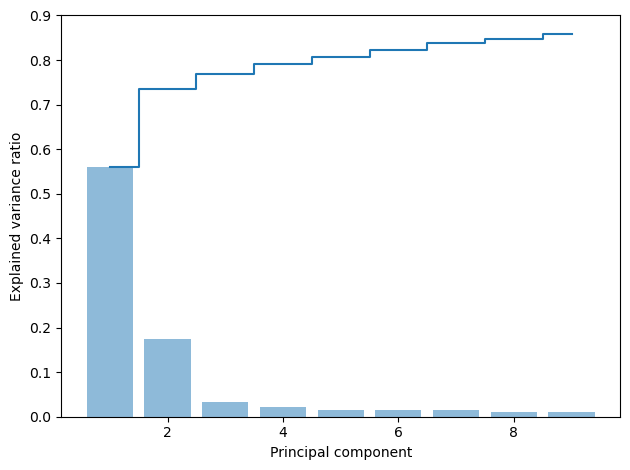

In [6]:
cum_var = np.cumsum(var)

plt.bar(range(1,len(var) + 1),var, alpha = 0.5, align = 'center', label = 'Explained variance by component')
plt.step(range(1,len(var) + 1), cum_var, where = 'mid', label = 'Cumulative explained variance')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.ylim(0,0.9)
plt.tight_layout()
plt.savefig('Sim_PCA_var.png')
plt.show()

In [7]:
pca_max = np.amax(sim_pca,axis = 0)
pca_min = np.amin(sim_pca,axis = 0)
scl_pca = sim_pca/(pca_max - pca_min)

The average silhouette value for 2 clusters is 0.17


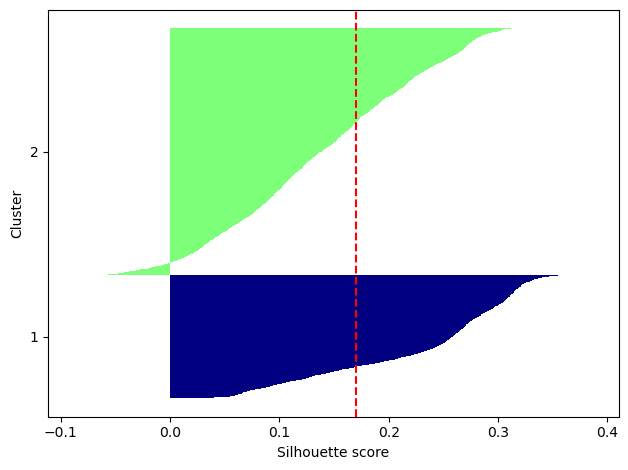

The average silhouette value for 3 clusters is 0.184


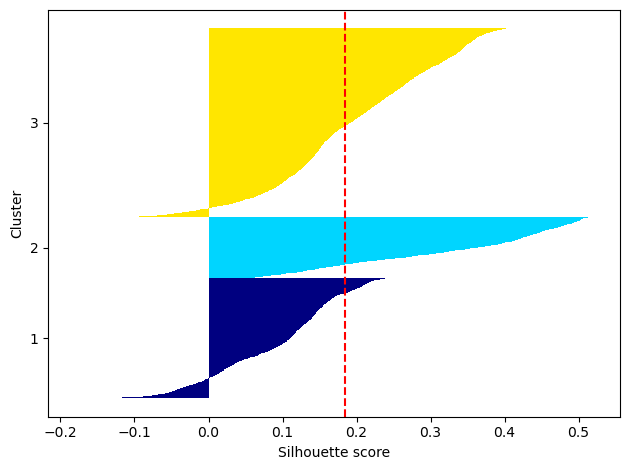

The average silhouette value for 4 clusters is 0.218


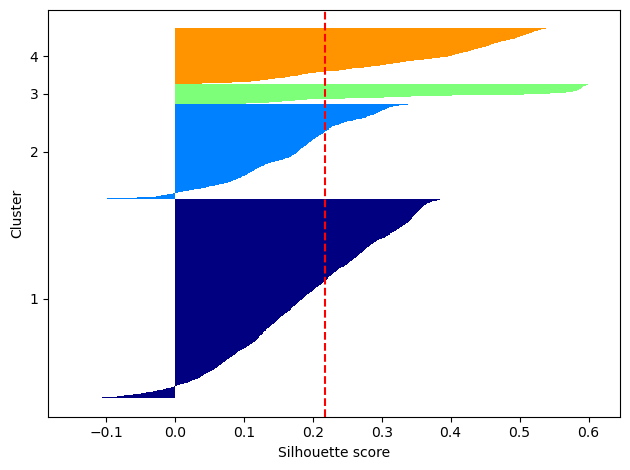

The average silhouette value for 5 clusters is 0.245


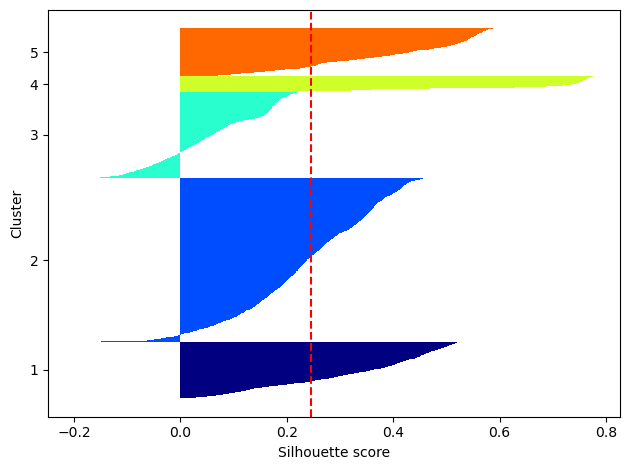

The average silhouette value for 6 clusters is 0.26


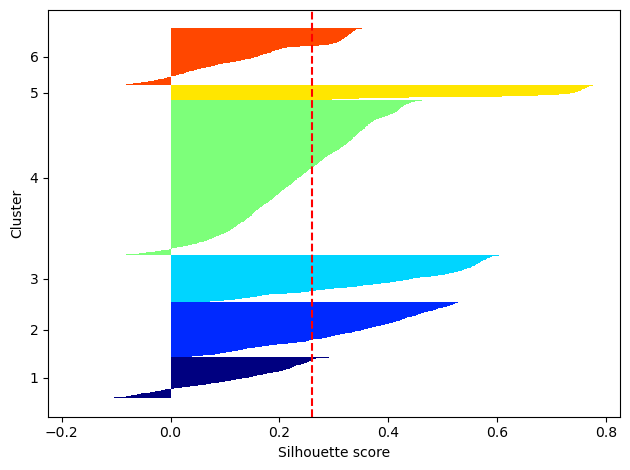

The average silhouette value for 7 clusters is 0.284


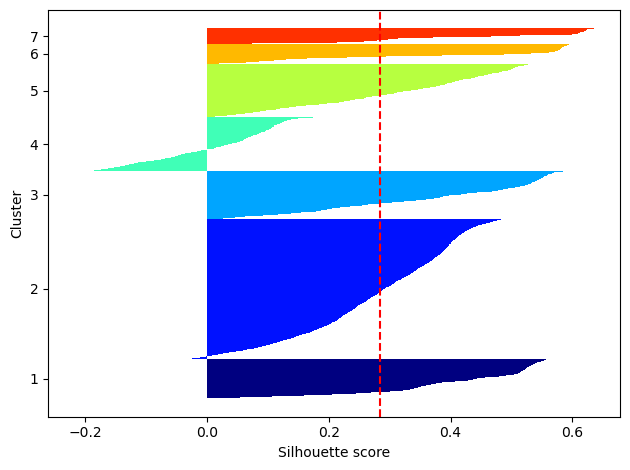

The average silhouette value for 8 clusters is 0.27


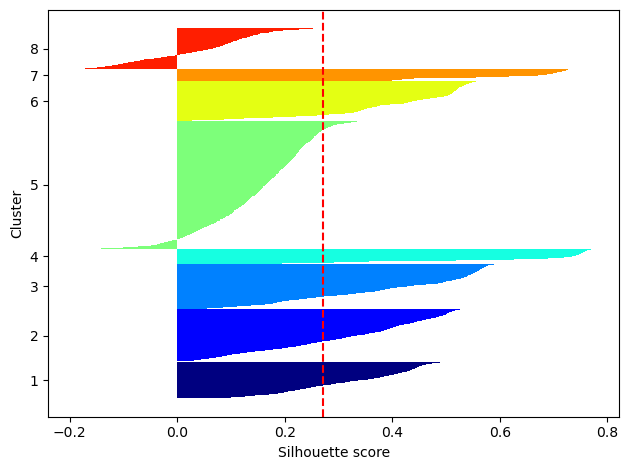

The average silhouette value for 9 clusters is 0.286


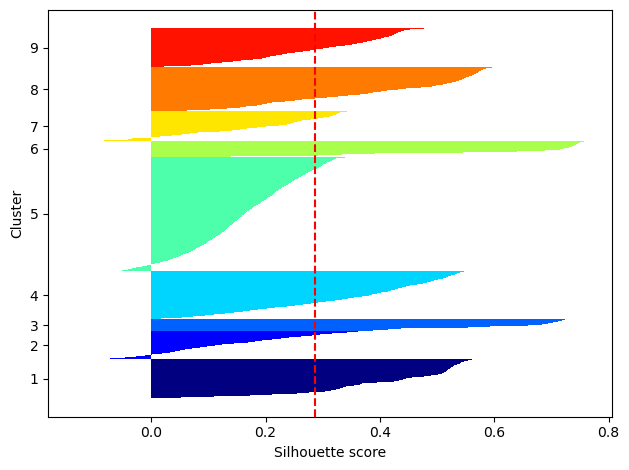

The average silhouette value for 10 clusters is 0.292


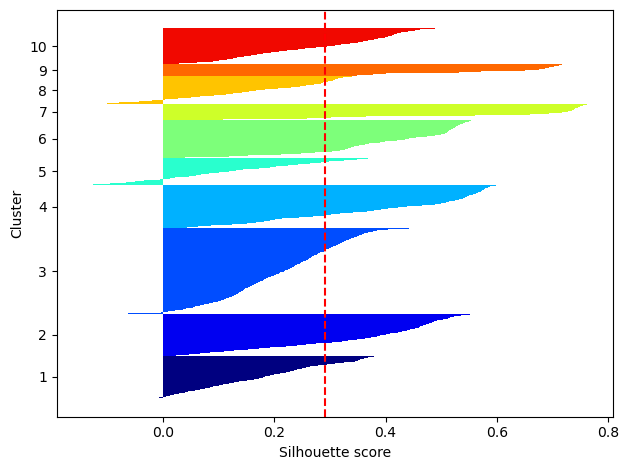

In [8]:
k_choice = list(range(2,11))
km_collection = {} #save y_km

for k in k_choice:
    km = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-04, random_state = 0)
    y_km = km.fit_predict(scl_pca)
    km_collection[f'{k}_clusters'] = y_km
    cluster_labels = np.unique(y_km)
    clust_nums = cluster_labels.shape[0]
    sil_vals = silhouette_samples(scl_pca, y_km, metric = 'euclidean')
    y_bottom, y_upper = 0,0
    yticks = []
    
    for i,j in enumerate(cluster_labels):
        j_sil_vals = sil_vals[y_km == j]
        j_sil_vals.sort()
        y_upper += len(j_sil_vals)
        color = cm.jet(float(i)/clust_nums)
        plt.barh(range(y_bottom, y_upper), j_sil_vals, height = 1, edgecolor = 'none', color = color)
        yticks.append((y_bottom + y_upper)/2)
        y_bottom += len(j_sil_vals)
    
    sil_avg = np.mean(sil_vals)
    plt.axvline(sil_avg, color = 'red', linestyle = '--')
    plt.yticks(yticks, cluster_labels + 1)
    print(f'The average silhouette value for {k} clusters is {round(sil_avg,3)}')
    plt.ylabel('Cluster')
    plt.xlabel("Silhouette score")
    plt.tight_layout()
    plt.savefig(f'{k}_clusters_sim_pca.png')
    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

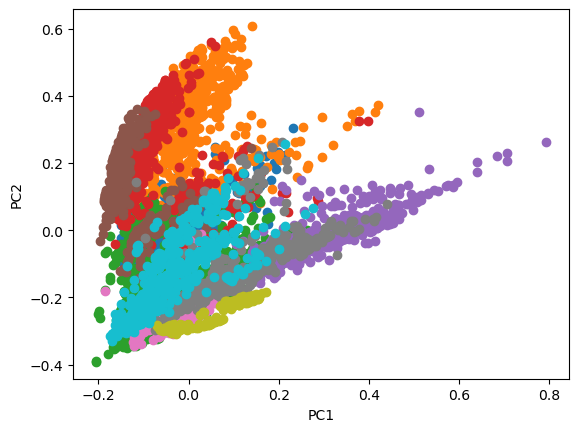

In [9]:
k = 10
for c in range(k):
    choice = km_collection[f'{k}_clusters']
    plt.scatter(scl_pca[choice == c,0], scl_pca[choice == c, 1])
    plt.savefig('sim_pca_cluster_analysis.png')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('sim_pca_cluster_analysis.png')
plt.show